# Generate mock data for a cluster

In this example we generate mock data with a variety of systematic effects including photometric redshifts, source galaxy distributions, and shape noise.  We then populate a galaxy cluster object. This notebooks is organised as follows:
- Imports and configuration setup
- Generate mock data with different source galaxy options
- Generate mock data with different field-of-view options
- Generate mock data with different galaxy cluster options (only available with the Numcosmo and/or CCL backends). Use the `os.environ['CLMM_MODELING_BACKEND']` line below to select your backend.

In [1]:
import os

## Uncomment the following line if you want to use a specific modeling backend among 'ct' (cluster-toolkit), 'ccl' (CCL) or 'nc' (Numcosmo). Default is 'ccl'
# os.environ['CLMM_MODELING_BACKEND'] = 'nc'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


In [3]:
import clmm

Make sure we know which version we're using

In [4]:
clmm.__version__

'1.12.0'

## Import mock data module and setup the configuration 

In [5]:
from clmm.support import mock_data as mock
from clmm import Cosmology

Mock data generation requires a defined cosmology

In [6]:
mock_cosmo = Cosmology(H0=70.0, Omega_dm0=0.27 - 0.045, Omega_b0=0.045, Omega_k0=0.0)

Mock data generation requires some cluster information. The default is to work with the NFW profile, using the "200,mean" mass definition. The Numcosmo and CCL backends allow for more flexibility (see last section of this notebook)

In [7]:
cosmo = mock_cosmo
cluster_id = "Awesome_cluster"
cluster_m = 1.0e15  # M200,m
cluster_z = 0.3
src_z = 0.8
concentration = 4
ngals = 1000  # number of source galaxies

# Cluster centre coordinates
cluster_ra = 50.0
cluster_dec = 87.0

It is also possible to choose the coordinate system for the generated ellipticities. Possible options are either "celestial" or "euclidean". The default choice is "euclidean". See https://doi.org/10.48550/arXiv.1407.7676 section 5.1 for more details.

In [ ]:
coordinate_system = "euclidean"

## Generate the mock catalog with different source galaxy options

- Clean data: no noise, all galaxies at the same redshift

In [8]:
zsrc_min = cluster_z + 0.1

In [9]:
ideal_data = mock.generate_galaxy_catalog(
    cluster_m,
    cluster_z,
    concentration,
    cosmo,
    src_z,
    ngals=ngals,
    cluster_ra=cluster_ra,
    cluster_dec=cluster_dec,
    coordinate_system=coordinate_system,
)

In [10]:
# let's put all these quantities in a single dictionary to facilitate clarity
cluster_kwargs = {
    "cluster_m": cluster_m,
    "cluster_z": cluster_z,
    "cluster_ra": cluster_ra,
    "cluster_dec": cluster_dec,
    "cluster_c": concentration,
    "cosmo": cosmo,
    "coordinate_system": coordinate_system,
}

In [11]:
ideal_data = mock.generate_galaxy_catalog(**cluster_kwargs, zsrc=src_z, ngals=ngals)

- Noisy data: shape noise, all galaxies at the same redshift

In [12]:
noisy_data_src_z = mock.generate_galaxy_catalog(
    **cluster_kwargs, zsrc=src_z, shapenoise=0.05, ngals=ngals
)

* Noisy data: shape noise plus measurement error, all galaxies at the same redshift

In [13]:
noisy_data_src_z_e_err = mock.generate_galaxy_catalog(
    **cluster_kwargs, zsrc=src_z, shapenoise=0.05, mean_e_err=0.05, ngals=ngals
)

<div class="alert alert-warning">

**WARNING:** Experimental feature. Uncertainties are created by simply drawing random numbers near the value specified by `mean_e_err`. Use at your own risk. This will be improved in future releases.
    
</div>

- Noisy data: photo-z errors (and pdfs!), all galaxies at the same redshift. At present, the pdfs are generated by drawing a random value from a Normal distribution with mean `ztrue` and width given by `dz = (1+z)*photoz_sigma_unscaled`, and the pdf is this Normal distribution centered around `z` instead of `ztrue`.

In [14]:
np.random.seed(41363)

noisy_data_photoz = mock.generate_galaxy_catalog(
    **cluster_kwargs,
    zsrc=src_z,
    shapenoise=0.05,
    photoz_sigma_unscaled=0.05,
    pz_bins=101,
    ngals=ngals
)

In [ ]:
noisy_data_photoz[:5]

* Changing ellipticity coordinate system: notice that $e_2$ changes sign!

In [ ]:
cluster_kwargs_celestial = cluster_kwargs.copy()
cluster_kwargs_celestial["coordinate_system"] = "celestial"

np.random.seed(41363)

noisy_data_photoz_celestial = mock.generate_galaxy_catalog(
    **cluster_kwargs_celestial,
    zsrc=src_z,
    shapenoise=0.05,
    photoz_sigma_unscaled=0.05,
    pz_bins=101,
    ngals=ngals
)

In [ ]:
noisy_data_photoz_celestial[:5]

In the default PDF storing (`pzpdf_type='shared_bins'`), the values of the PDF are added to the `pzpdf` column and the binning scheme is stored in the `pzpdf_info` attribute:

In [15]:
noisy_data_photoz.pzpdf_info

{'type': 'shared_bins',
 'zbins': array([0.        , 0.02002398, 0.04004797, 0.06007195, 0.08009594,
        0.10011992, 0.12014391, 0.14016789, 0.16019188, 0.18021586,
        0.20023985, 0.22026383, 0.24028782, 0.2603118 , 0.28033579,
        0.30035977, 0.32038376, 0.34040774, 0.36043173, 0.38045571,
        0.40047969, 0.42050368, 0.44052766, 0.46055165, 0.48057563,
        0.50059962, 0.5206236 , 0.54064759, 0.56067157, 0.58069556,
        0.60071954, 0.62074353, 0.64076751, 0.6607915 , 0.68081548,
        0.70083947, 0.72086345, 0.74088744, 0.76091142, 0.78093541,
        0.80095939, 0.82098337, 0.84100736, 0.86103134, 0.88105533,
        0.90107931, 0.9211033 , 0.94112728, 0.96115127, 0.98117525,
        1.00119924, 1.02122322, 1.04124721, 1.06127119, 1.08129518,
        1.10131916, 1.12134315, 1.14136713, 1.16139112, 1.1814151 ,
        1.20143908, 1.22146307, 1.24148705, 1.26151104, 1.28153502,
        1.30155901, 1.32158299, 1.34160698, 1.36163096, 1.38165495,
        1.40167

In [16]:
noisy_data_photoz[:5]

ra,dec,e1,e2,z,ztrue,pzpdf,id
float64,float64,float64,float64,float64,float64,float64[101],int64
47.81401898069192,86.94242334870393,-0.030878071328624277,-0.037501208508942806,0.9249341947671276,0.8,5.153214617028245e-23 .. 3.3429178343223385e-31,0
51.204027141855086,87.08990010959847,-0.046538892914399776,0.016938121129503367,0.7142243042697253,0.8,9.360833884755997e-14 .. 1.449332911815105e-44,1
48.25887782017473,87.09803862800872,0.033540670972289,0.004871311035019964,0.7886718766448225,0.8,9.371624310593116e-17 .. 1.4272305118379792e-39,2
46.138291847936785,87.23039081500953,0.0351225655841045,0.0007676631696667513,0.9535675074334966,0.8,1.8626044950214912e-24 .. 1.4331518431409574e-29,3
46.3820424107883,86.79081814232967,-0.012986698648986016,-0.07259485635320272,0.699180072675543,0.8,3.478204186516279e-13 .. 1.306269700871814e-45,4


It is also possible to generate individual binning of the PDF with `pzpdf_type='individual_bins'`. In this case, both the bin values and the PDF are added to the `pzpdf` column:

In [17]:
mock.generate_galaxy_catalog(
    **cluster_kwargs,
    zsrc=src_z,
    shapenoise=0.05,
    photoz_sigma_unscaled=0.05,
    pz_bins=101,
    ngals=ngals,
    pzpdf_type="individual_bins"
)[:5]

ra,dec,e1,e2,z,ztrue,pzbins,pzpdf,id
float64,float64,float64,float64,float64,float64,float64[101],float64[101],int64
49.64330802191032,87.07935209760659,-0.0669198148836149,-0.09012107147111961,0.8088167080061867,0.8,0.0 .. 1.7088167080061867,1.2855625759901305e-17 .. 8.54955402967386e-22,0
46.535419444969655,86.85064364078734,-0.024947980405211012,-0.09247072962276147,0.7199859311512362,0.8,0.0 .. 1.6199859311512363,5.6206590711725123e-14 .. 8.549554029673739e-22,1
48.35431738223301,87.00512300439964,0.003692608028864815,0.014850454740407262,0.8161078112571118,0.8,0.0 .. 1.716107811257112,6.1870278859959564e-18 .. 8.549554029673739e-22,2
46.29661789274337,87.06092100913939,0.030704342564381867,0.05262061351215345,0.7901245339854833,0.8,0.0 .. 1.6901245339854833,8.134509418129969e-17 .. 8.54955402967386e-22,3
48.23019085658031,86.97666127128494,-0.0006266115761144631,-0.029997264160079487,0.6304580232818315,0.8,0.0 .. 1.5304580232818317,9.794354180545214e-11 .. 8.549554029673739e-22,4


Note that if `pzpdf_type=None`, the pdf is not stored:

In [18]:
mock.generate_galaxy_catalog(
    **cluster_kwargs,
    zsrc=src_z,
    shapenoise=0.05,
    photoz_sigma_unscaled=0.05,
    pz_bins=101,
    ngals=ngals,
    pzpdf_type=None
)[:5]

ra,dec,e1,e2,z,ztrue,id
float64,float64,float64,float64,float64,float64,int64
47.01304836146967,86.90320776906412,0.04858390225775316,0.08529253532455781,0.7011581027350866,0.8,0
45.22315522979897,87.13889718885446,-0.0842016935152235,-0.03032599957608561,0.8585539174947612,0.8,1
53.96284782899198,86.99665806469687,-0.042277801543898375,-0.0551193068736569,0.745960886019372,0.8,2
48.23273684184402,87.1965261859118,0.0696199654019288,-0.030253463436142436,0.8258255147859316,0.8,3
51.68354189570964,87.07679835674433,-0.02229984925586568,-0.020553882389932544,0.9109653448388446,0.8,4


- Clean data: source galaxy redshifts drawn from a redshift distribution instead of fixed `src_z` value. Options are `chang13` for Chang et al. 2013 or `desc_srd` for the distribution given in the DESC Science Requirement Document. No shape noise or photoz errors.

In [19]:
ideal_with_src_dist = mock.generate_galaxy_catalog(
    **cluster_kwargs, zsrc="chang13", zsrc_min=zsrc_min, zsrc_max=7.0, ngals=ngals
)

- Noisy data: galaxies following redshift distribution, redshift error, shape noise

In [20]:
pzbins = np.linspace(0, 10, 1001)

In [21]:
allsystematics = mock.generate_galaxy_catalog(
    **cluster_kwargs,
    zsrc="chang13",
    zsrc_min=zsrc_min,
    photoz_sigma_unscaled=0.05,
    ngals=ngals,
    pz_bins=pzbins,
)

In [22]:
allsystematics2 = mock.generate_galaxy_catalog(
    **cluster_kwargs,
    zsrc="desc_srd",
    zsrc_min=zsrc_min,
    zsrc_max=7.0,
    photoz_sigma_unscaled=0.05,
    ngals=ngals,
    pz_bins=pzbins,
    shapenoise=0.05,
)

Sanity check: checking that no galaxies were originally drawn below zsrc_min, before photoz errors are applied (when relevant)

In [23]:
print(
    f"""Number of galaxies below zsrc_min:
    ideal_data          : {np.sum(ideal_data['ztrue']<zsrc_min):5,}
    noisy_data_src_z    : {np.sum(noisy_data_src_z['ztrue']<zsrc_min):5,}
    noisy_data_photoz   : {np.sum(noisy_data_photoz['ztrue']<zsrc_min):5,}
    ideal_with_src_dist : {np.sum(ideal_with_src_dist['ztrue']<zsrc_min):5,}
    allsystematics      : {np.sum(allsystematics['ztrue']<zsrc_min):5,}
"""
)

Number of galaxies below zsrc_min:
    ideal_data          :     0
    noisy_data_src_z    :     0
    noisy_data_photoz   :     0
    ideal_with_src_dist :     0
    allsystematics      :     0



### Inspect the catalog data

- Ideal catalog first entries: no noise on the shape measurement, all galaxies at z=0.8, no redshift errors (z = ztrue)

In [24]:
for n in ideal_data.colnames:
    if n != "id":
        ideal_data[n].format = "%6.3e"
ideal_data[0:3].show_in_notebook()

idx,ra,dec,e1,e2,z,ztrue,id
0,5.317e+01,8.682e+01,3.759e-05,-7.851e-03,8.000e-01,8.000e-01,0
1,4.774e+01,8.720e+01,4.703e-03,-7.239e-03,8.000e-01,8.000e-01,1
2,5.294e+01,8.693e+01,-8.369e-03,-9.173e-03,8.000e-01,8.000e-01,2


- With photo-z errors

In [25]:
for n in noisy_data_photoz.colnames:
    if n != "id":
        noisy_data_photoz[n].format = "%6.3e"
noisy_data_photoz[0:3].show_in_notebook()

idx,ra,dec,e1,e2,z,ztrue,pzpdf,id
0,4.781e+01,8.694e+01,-3.088e-02,-3.750e-02,9.249e-01,8.000e-01,5.153e-23 .. 3.343e-31,0
1,5.120e+01,8.709e+01,-4.654e-02,1.694e-02,7.142e-01,8.000e-01,9.361e-14 .. 1.449e-44,1
2,4.826e+01,8.710e+01,3.354e-02,4.871e-03,7.887e-01,8.000e-01,9.372e-17 .. 1.427e-39,2


- Histogram of the redshift distribution of background galaxies, for the true (originally drawn) redshift and the redshift once photoz errors have been added, and the stacked pdf. By construction no true redshift occurs below zsrc_min, but some 'observed' redshifts (i.e. including photoz errors) might be.

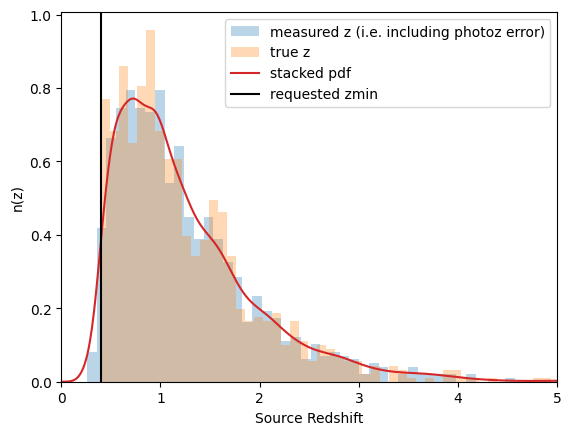

In [26]:
plt.hist(
    allsystematics["z"],
    bins=50,
    alpha=0.3,
    density=True,
    label="measured z (i.e. including photoz error)",
)
plt.hist(allsystematics["ztrue"], bins=50, alpha=0.3, density=True, label="true z")
stacked_pdf = np.mean(allsystematics["pzpdf"], axis=0)
plt.plot(allsystematics.pzpdf_info["zbins"], stacked_pdf, "C3", label="stacked pdf")
plt.axvline(zsrc_min, color="k", label="requested zmin")
plt.xlabel("Source Redshift")
plt.ylabel("n(z)")
plt.legend()
plt.xlim(0, 5)
pass

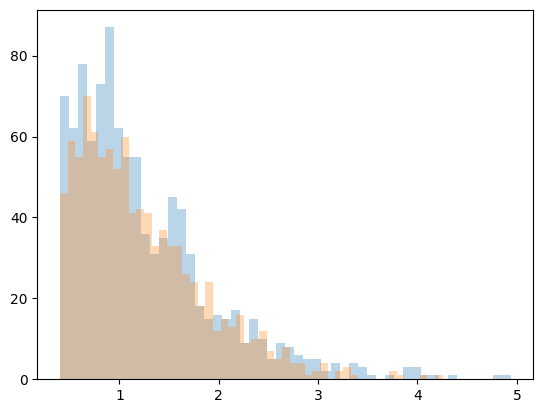

In [27]:
plt.hist(allsystematics["ztrue"], bins=50, alpha=0.3, label="true z")
plt.hist(allsystematics2["ztrue"], bins=50, alpha=0.3, label="true z")

## Populate a galaxy cluster object

In [28]:
gc_object = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec, cluster_z, allsystematics)

From a `GalaxyCluster` object that has photoz information, `draw_gal_z_from_pdz` allows to generate `nobj` random redshifts of each galaxy in `galcat`, from its photoz pdf, and store the result in a new `zcol_out` column.

In [29]:
z_random = gc_object.draw_gal_z_from_pdz(zcol_out="z_random", overwrite=False, nobj=1)

The plot below shows the "observed photoz pdf" (blue), centered on the "observed z" (red), the true redshift from which the shear where computed (green) and  a random redshift (orange) computed from the pdf

(3.223044987263456, 4.223044987263457)

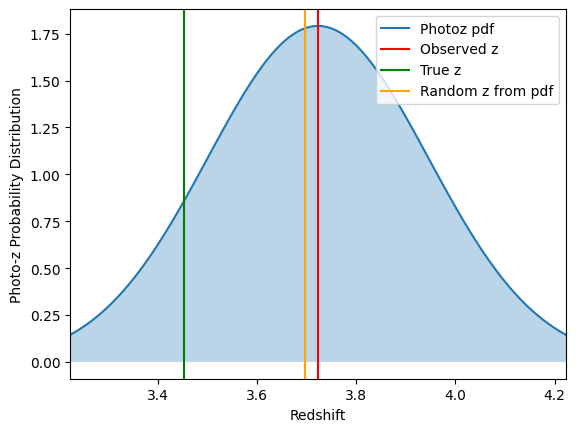

In [30]:
# p(z) for one of the galaxies in the catalog,
galid = 0
plt.fill(gc_object.galcat.pzpdf_info["zbins"], allsystematics["pzpdf"][galid], alpha=0.3)
plt.plot(gc_object.galcat.pzpdf_info["zbins"], gc_object.galcat["pzpdf"][galid], label="Photoz pdf")

plt.axvline(gc_object.galcat["z"][galid], label="Observed z", color="red")
plt.axvline(gc_object.galcat["ztrue"][galid], label="True z", color="g")
plt.axvline(gc_object.galcat["z_random"][galid], label="Random z from pdf", color="orange")

plt.xlabel("Redshift")
plt.ylabel("Photo-z Probability Distribution")
plt.legend(loc=1)
plt.xlim(gc_object.galcat["z"][galid] - 0.5, gc_object.galcat["z"][galid] + 0.5)

Plot source galaxy ellipticities

Text(0, 0.5, 'Ellipticity 2')

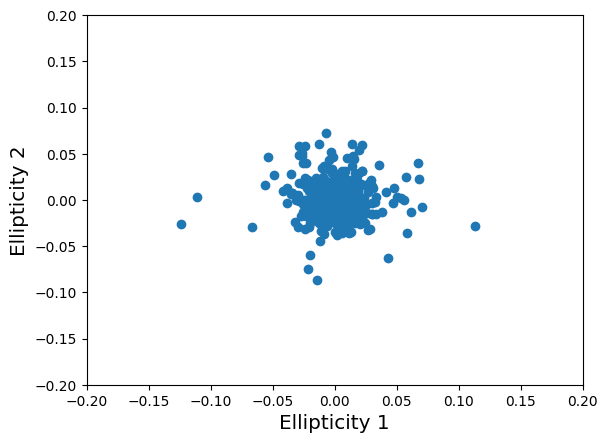

In [31]:
plt.scatter(gc_object.galcat["e1"], gc_object.galcat["e2"])

plt.xlim(-0.2, 0.2)
plt.ylim(-0.2, 0.2)
plt.xlabel("Ellipticity 1", fontsize="x-large")
plt.ylabel("Ellipticity 2", fontsize="x-large")

## Generate the mock data catalog with different field-of-view options

In the examples above, `ngals=1000` galaxies were simulated in a field corresponding to a 8 Mpc x 8 Mpc (proper distance) square box at the cluster redshift (this is the default). The user may however vary the field size and/or provide a galaxy density (instead of a number of galaxies). This is examplified below, using the `allsystematics` example.

- `ngals = 1000` in a 4 x 4 Mpc box. Asking for the same number of galaxies in a smaller field of view yields high galaxy density

In [32]:
allsystematics2 = mock.generate_galaxy_catalog(
    **cluster_kwargs,
    zsrc="chang13",
    zsrc_min=zsrc_min,
    zsrc_max=7.0,
    shapenoise=0.05,
    photoz_sigma_unscaled=0.05,
    field_size=4,
    ngals=ngals
)

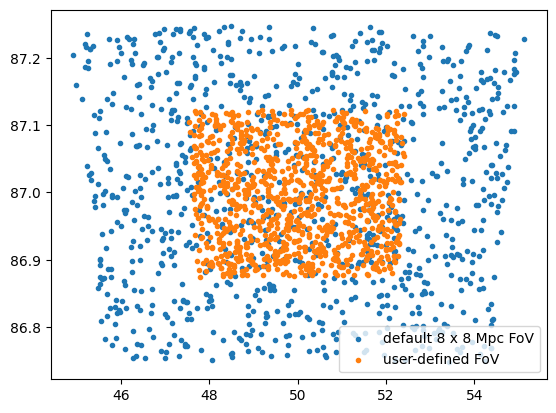

In [33]:
plt.scatter(allsystematics["ra"], allsystematics["dec"], marker=".", label="default 8 x 8 Mpc FoV")
plt.scatter(allsystematics2["ra"], allsystematics2["dec"], marker=".", label="user-defined FoV")
plt.legend()

- Alternatively, the user may provide a galaxy density (here ~1 gal/arcmin2 to roughly match 1000 galaxies, given the configuration) and the number of galaxies to draw will automatically be adjusted to the box size.

In [34]:
allsystematics3 = mock.generate_galaxy_catalog(
    **cluster_kwargs,
    zsrc="chang13",
    zsrc_min=zsrc_min,
    zsrc_max=7.0,
    shapenoise=0.05,
    photoz_sigma_unscaled=0.05,
    ngal_density=1.3,
)
print(f"Number of drawn galaxies = {len(allsystematics3)}")

Number of drawn galaxies = 989


In [35]:
allsystematics4 = mock.generate_galaxy_catalog(
    **cluster_kwargs,
    zsrc="desc_srd",
    zsrc_min=zsrc_min,
    zsrc_max=7.0,
    shapenoise=0.05,
    photoz_sigma_unscaled=0.05,
    ngal_density=1.3,
)
print(f"Number of drawn galaxies = {len(allsystematics4)}")

Number of drawn galaxies = 1020


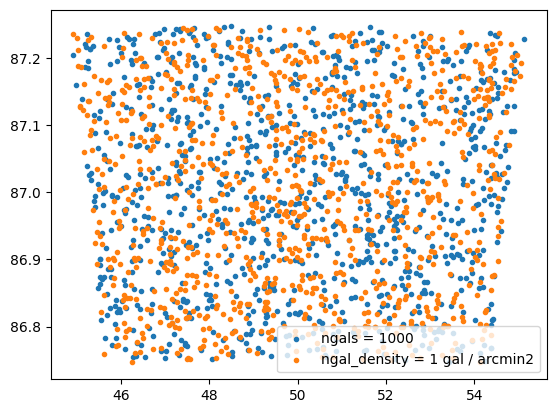

In [36]:
plt.scatter(allsystematics["ra"], allsystematics["dec"], marker=".", label="ngals = 1000")
plt.scatter(
    allsystematics3["ra"],
    allsystematics3["dec"],
    marker=".",
    label="ngal_density = 1 gal / arcmin2",
)
plt.legend()

## Generate mock data with different galaxy cluster options
WARNING: Available options depend on the modeling backend:
- Cluster-toolkit allows for other values of the overdensity parameter, but is retricted to working with the mean mass definition
- Both CCL and Numcosmo allow for different values of the overdensity parameter, but work with both the mean and critical mass definition
- Numcosmo further allows for the Einasto or Burkert density profiles to be used instead of the NFW profile



### Changing the overdensity parameter (all backend) - `delta_so` keyword (default = 200)

In [37]:
allsystematics_500mean = mock.generate_galaxy_catalog(
    **cluster_kwargs,
    zsrc="chang13",
    delta_so=500,
    zsrc_min=zsrc_min,
    zsrc_max=7.0,
    shapenoise=0.05,
    photoz_sigma_unscaled=0.05,
    ngals=ngals
)

### Using the critical mass definition (Numcosmo and CCL only) - `massdef` keyword (default = 'mean')
WARNING: error will be raised if using the cluster-toolkit backend

In [38]:
allsystematics_200critical = mock.generate_galaxy_catalog(
    **cluster_kwargs,
    zsrc="chang13",
    massdef="critical",
    zsrc_min=zsrc_min,
    zsrc_max=7.0,
    shapenoise=0.05,
    photoz_sigma_unscaled=0.05,
    ngals=ngals
)

### Changing the halo density profile (Numcosmo and CCL only) - `halo_profile_model` keyword (default = 'nfw')
WARNING: error will be raised if using the cluster-toolkit or CCL backends

In [39]:
allsystematics_200m_einasto = mock.generate_galaxy_catalog(
    **cluster_kwargs,
    zsrc="chang13",
    halo_profile_model="einasto",
    zsrc_min=zsrc_min,
    zsrc_max=7.0,
    shapenoise=0.05,
    photoz_sigma_unscaled=0.05,
    ngals=ngals
)

In [51]:
ideal_data

ra,dec,e1,e2,z,ztrue,id
float64,float64,float64,float64,float64,float64,int64
5.317e+01,8.682e+01,3.759e-05,-7.851e-03,8.000e-01,8.000e-01,0
4.774e+01,8.720e+01,4.703e-03,-7.239e-03,8.000e-01,8.000e-01,1
5.294e+01,8.693e+01,-8.369e-03,-9.173e-03,8.000e-01,8.000e-01,2
5.333e+01,8.689e+01,-5.125e-03,-8.493e-03,8.000e-01,8.000e-01,3
4.802e+01,8.723e+01,5.498e-03,-5.411e-03,8.000e-01,8.000e-01,4
4.833e+01,8.717e+01,6.882e-03,-8.367e-03,8.000e-01,8.000e-01,5
5.179e+01,8.689e+01,1.993e-03,-1.476e-02,8.000e-01,8.000e-01,6
4.970e+01,8.724e+01,8.318e-03,-1.024e-03,8.000e-01,8.000e-01,7
...,...,...,...,...,...,...


In [12]:
from astropy import wcs
dx = -1.0 / 60.0
dy =  1.0 / 60.0

w = wcs.WCS(naxis = 2)

w.wcs.crval = [cluster_ra, cluster_dec]
w.wcs.cd    = np.array([[dx, 0.0], [0.0, dy]])
w.wcs.ctype = ['RA---TAN', 'DEC--TAN']
w.wcs.crpix = [0, 0]

coord = np.stack([ideal_data['ra'], ideal_data['dec']], axis = 1)
    
xy = w.wcs_world2pix(coord, 1)

x = xy[:,0]
y = xy[:,1]

In [13]:
ltmin  =  0.0
ltmax  =  1.28
dlt    =  0.16

nbin = int((ltmax - ltmin + 1.0e-30) / dlt)

lt1 = np.linspace(ltmin, ltmax - dlt, num = nbin)
lt2 = np.linspace(ltmin + dlt, ltmax, num = nbin)

tbin = 10 ** (0.5 * (lt1 + lt2))

t  = np.sqrt(x * x + y * y)
lt = np.log10(t)

In [14]:
cos2 = (x * x - y * y) / (t * t + 1.0e-30)
sin2 = 2.0 * x * y  / (t * t + 1.0e-30)

gt = (-1.0) * cos2 * ideal_data['e1'] - sin2 * ideal_data['e2']
gx = sin2 * ideal_data['e1'] - cos2 * ideal_data['e2']

In [15]:
gt_ave = np.zeros(nbin)
gx_ave = np.zeros(nbin)
gt_sig = np.zeros(nbin)
gx_sig = np.zeros(nbin)
weight = np.ones(np.shape(gt)[0])
for j in range(nbin):
    mask = np.logical_and((lt > lt1[j]), (lt < lt2[j]))
    ct   = t[mask]
    cgt  = gt[mask]
    cgx  = gx[mask]
    cwei = weight[mask]

    wsum1 = np.sum(cwei)
    wsum2 = np.sum(cwei * cwei)

    gt_ave[j] = np.sum(cgt * cwei) / wsum1
    gx_ave[j] = np.sum(cgx * cwei) / wsum1

    gt_sig[j] = np.sqrt((np.sum(cgt * cgt * cwei) / wsum1) * (wsum2 / (wsum1 * wsum1)))
    gx_sig[j] = np.sqrt((np.sum(cgx * cgx * cwei) / wsum1) * (wsum2 / (wsum1 * wsum1)))

In [16]:
import matplotlib as mpl

Text(0, 0.5, '$\\gamma_+$ or $\\gamma_\\times$')

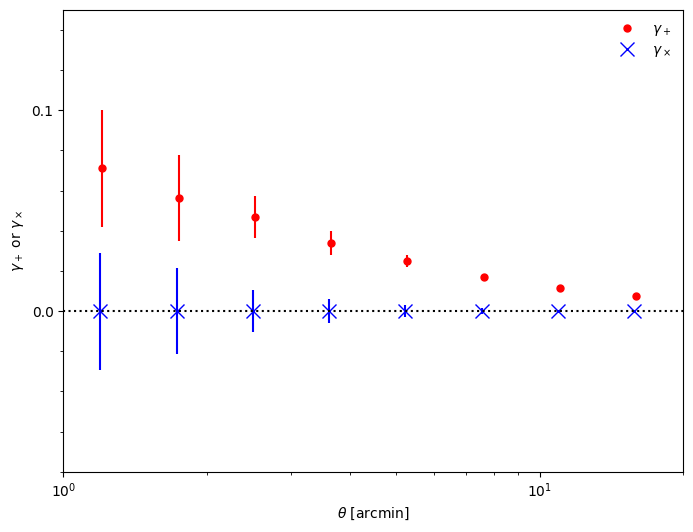

In [17]:
xmin = 1.0
xmax = 20.0
ymin = -0.08
ymax = 0.15

plt.figure(figsize = (8, 6))


plt.plot(tbin * 1.005, gt_ave, '.', markersize = 10, color = 'r')
plt.errorbar(tbin * 1.005, gt_ave, yerr = gt_sig, fmt = 'none', ecolor = 'r', label = '_nolegend_')

plt.plot(tbin * 0.995, gx_ave, 'x', markersize = 10, color = 'b')
plt.errorbar(tbin * 0.995, gx_ave, yerr = gt_sig, fmt = 'none', ecolor = 'b', label = '_nolegend_')

plt.legend(['$\gamma_+$', '$\gamma_\\times$'], markerscale = 1, frameon = False, labelspacing = 0.3, numpoints = 1, loc = 'upper right')

plt.hlines(0, xmin, xmax, linestyles = 'dotted', color = 'black')
ax = plt.gca()
ax.set_xscale('log')

ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.02))

plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])

plt.xlabel('$\\theta$ [arcmin]')
plt.ylabel('$\gamma_+$ or $\gamma_\\times$')
#plt.title('ideal data')

In [18]:
from scipy.optimize import curve_fit

In [19]:
def fit_sis(x, t_ein):
    return 0.5 * (t_ein / x)

# fit parameter t_ein (Einstein radius) with observed shear profile
tein, cov = curve_fit(fit_sis, tbin, gt_ave, sigma = gt_sig)

print('Einstein radius: %f arcmin' % tein[0])

Einstein radius: 0.248294 arcmin


Text(0.5, 1.0, 'ideal data')

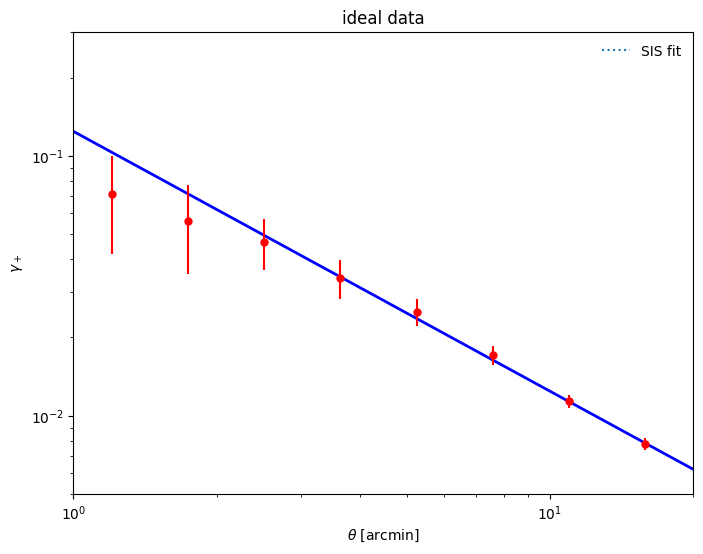

In [20]:
# conpute best-fit profile
tt1 = 10 ** np.linspace(-1.0, 2.0, num = 300)
yy1 = fit_sis(tt1, tein[0])

xmin = 1.0
xmax = 20.0
ymin = 0.005
ymax = 0.3

plt.figure(figsize = (8, 6))

plt.hlines(0, xmin, xmax, linestyles = 'dotted')

plt.plot(tt1, yy1, '-', color = 'b', lw = 2.)

plt.plot(tbin, gt_ave, '.', markersize = 10, color = 'r')
plt.errorbar(tbin, gt_ave, yerr = gt_sig, fmt = 'none', ecolor = 'r', label = '_nolegend_')

plt.legend(['SIS fit'], markerscale = 1, frameon = False, labelspacing = 0.3, numpoints = 1, loc = 'upper right')

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])

plt.xlabel('$\\theta$ [arcmin]')
plt.ylabel('$\gamma_+$')
plt.title('ideal data')

In [21]:
from astropy import constants as const
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0 = 70, Om0 = 0.27 - 0.045)

In [22]:
tein_rad = tein[0] * u.arcmin
dos = cosmo.angular_diameter_distance(src_z)
dol = cosmo.angular_diameter_distance(cluster_z)
dls = cosmo.angular_diameter_distance_z1z2(cluster_z, src_z)
sig = const.c * np.sqrt((tein_rad * dos).to(u.Mpc, u.dimensionless_angles()) / (4.0 * np.pi * dls))

print('velocity dispersion: ', sig.to(u.km/u.s))

velocity dispersion:  942.4740599399456 km / s


In [23]:
from colossus.halo import concentration
from colossus.halo import profile_nfw
from colossus.cosmology import cosmology
params = {'flat': True, 'H0': 70.0, 'Om0': 0.27 - 0.045, 'Ob0': 0.045, 'sigma8': 0.81, 'ns': 0.95}
cosmology.addCosmology('myCosmo', **params)
cosmo_c = cosmology.setCosmology('myCosmo')

In [24]:
def calc_R200m(halo_mass,redshift=0.25):
    concen = concentration.concentration(halo_mass,'200m',redshift,model='diemer15')
   
    profile = profile_nfw.NFWProfile(M=halo_mass,mdef='200m',z=redshift,c=concen)
    R200m = profile.RDelta(redshift,'200m')
    R200m /= 1000. #ts: convert to Mpc/h                                                                                            
    return concen,R200m

In [25]:
def convert_M200m_to_Mvir(halo_mass,redshift=0.25):
    concen = concentration.concentration(halo_mass,'200m',redshift,model='diemer15')
    profile = profile_nfw.NFWProfile(M=halo_mass,mdef='200m',z=redshift,c=concen)
    Rvir = profile.RDelta(redshift,'vir')
    Mvir = profile.enclosedMass(Rvir)
    return concen,Rvir/1000.,Mvir

In [26]:
concen,R200m = calc_R200m(10**15.,redshift=cluster_z)
cvir,Rvir,Mvir = convert_M200m_to_Mvir(10**15.,redshift=cluster_z)

In [27]:
G = 4.299*10**(-9) #unit:[Mpc(km/s)^2 Msun^-1]  
Mhalo = 10**15.
hubble = cosmo.H(cluster_z)
a_z = 1./(1.+cluster_z)
sigma = G*(Mhalo)/R200m/a_z**2. #TS:[(Mpc/h)^2]

In [28]:
np.sqrt(sigma)

1879.4711300482945